# Comparing NDVI for Conservation and non conservation agricultur

## Defining the Problem
We have 8 fields comparison plots with a Conversational and a non conversational agricultural field neighbouring each other. Of these 1 is a  pilot (nr 7) which consists of small subplots with in a larger field is excludes from the NDVI calculation since the subplots are too small to isolate on the landsat image. For

## Overall workflow
1. Setup the GEE work environment
2. Load the fields from Github
3. Extract the Landsat data for the given areas and period
4. Identify which pixels are within which fields/treatments (Intersect)
5. Process the pixels (Decode quality byte, convert the time stamp to Year, Month Day)
6. Join filed/treatment data to the pixels
7. Filter pixels for clouds
8. Calculate the average NDVI for each Year, Month for each field/treatment

## Processing

### Setup the environment

In [ ]:
import ee
import numpy as np
import geemap
import os
import pandas as pd
import geopandas as gpd

If the machine is a new one copy the gee credentials

In [ ]:
geemap.ee_initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=DGx96aeae0KTaBya8_f3cdjPWVwpZ9mjUE7-fjkytEI&tc=Z-K9hEqWMEvY2-XNYJ_vKuddviBN1GT1qR6PaS3-5mg&cc=DPHLhy3yp8y8zxzCBlfeLLt2lNDwldzUn8vGOfLQXfI

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AeaYSHCQ9rNcd-KHUaBfKi9TN_ETbEfBKHLGgxc9iko0PvklrCB2EIpoxLs

Successfully saved authorization token.


### Load Data
Load a geojson document that defines the field and treatment type for each pixel

In [ ]:
fields = gpd.read_file("https://raw.githubusercontent.com/Esbern/conservation-agriculture/main/sampel_fields.geojson")

In [ ]:
attribute_to_color = {
    'CT': '#FF0000',  # Red
    'MT': '#00FF00',  # Green
}
fields['color'] = fields['tillage'].map(attribute_to_color)
Map = geemap.Map(center=(55, 13), zoom=4)
Map.add_gdf(fields, layer_name="Fields",
            style_callback=lambda x: {'fillColor': x['properties']['color']})
Map

Map(center=[55, 13], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

### Extract the Landsat data for the given areas and period

In [ ]:
# Convert Dataframe to ee object
fields_ee = geemap.geopandas_to_ee(fields)

In [ ]:
# Identify Landsat images covering the fields for the given priod
L7 = ee.ImageCollection("LANDSAT/LE07/C02/T1_TOA")
col = L7 \
  .filterBounds(fields_ee) \
  .filterDate('2010-01-01', '2016-01-01') \
  .select('B3','B4','QA_PIXEL')
count = col.size()
count


In [ ]:
# Collect the pixel values and convert them to a local dataframe

pixelInfoBbox= col.getRegion(geometry=fields_ee,scale=30)
pixelList = pixelInfoBbox.getInfo()
all_pixels_df = pd.DataFrame(pixelList[1:], columns=pixelList[0])

### Identify which pixels are within which fields/treatments (Intersect)


In [ ]:
#Extract all unique pixel coordinates and convert them to a GeoPandas dataframe
pixel_df = all_pixels_df.groupby(['longitude', 'latitude']).size().reset_index(name='counts')
pixels_gdf = gpd.GeoDataFrame(
    pixel_df, geometry=gpd.points_from_xy(pixel_df.longitude, pixel_df.latitude), crs="EPSG:4326"
)
pixel_fields_gdf = gpd.overlay( pixels_gdf,fields, how='intersection')

In [ ]:
def style_function(feature):
    return {
        'color': feature['properties']['color'],  # This sets the border color
        'fillColor': feature['properties']['color'],  # This sets the fill color
        'fillOpacity': 0.5,
        'weight': 1,
    }

Map = geemap.Map(center=(55, 13), zoom=4)
Map.add_gdf(fields, layer_name="Fields",
            style_callback=lambda x: {'fillColor': x['properties']['color']})
Map.add_gdf(pixel_fields_gdf, layer_name="pixels")

Map

Map(center=[55, 13], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

### Process the pixels (Caclulate NDVIFilter pixels for clouds and convert the time stamp to Year, Month Day)

In [ ]:
#Process Time and NDVI
all_pixels_df['time'] = pd.to_datetime(all_pixels_df['time'], unit='ms')

# Extract year, month, and day to separate columns
all_pixels_df['year'] = all_pixels_df['time'].dt.year
all_pixels_df['month'] = all_pixels_df['time'].dt.month
all_pixels_df['day'] = all_pixels_df['time'].dt.day

# Calculate NDVI and add it as a new column
all_pixels_df['NDVI'] = (all_pixels_df['B4'] - all_pixels_df['B3']) / (all_pixels_df['B4'] + all_pixels_df['B3'])

# Handle potential division by zero or NaN values
all_pixels_df['NDVI'] = all_pixels_df['NDVI'].replace([np.inf, -np.inf], np.nan)



In [ ]:
# Function to decode the QA_PIXEL column, modified to handle NaN values
def decode_qa_pixel(value):
    # Check if the value is NaN and return NaN for all attributes if true
    if pd.isna(value):
        return pd.Series([np.nan] * 11, index=[
            'Fill', 'Dilated Cloud', 'Cloud', 'Cloud Shadow', 'Snow',
            'Clear', 'Water', 'Cloud Confidence', 'Cloud Shadow Confidence',
            'Snow/Ice Confidence', 'Cirrus Confidence'])

    # Convert float to int and then to binary string, stripping the '0b' prefix
    binary_str = format(int(value), '016b')

    # Decode each bit based on the descriptions provided
    attributes = {
        'Fill': 'Fill data' if binary_str[-1] == '1' else 'Image data',
        'Dilated Cloud': 'Cloud dilation' if binary_str[-2] == '1' else 'Cloud is not dilated or no cloud',
        'Cloud': 'High confidence cloud' if binary_str[-4] == '1' else 'Cloud confidence is not high',
        'Cloud Shadow': 'High confidence cloud shadow' if binary_str[-5] == '1' else ' Cloud Shadow Confidence is not high',
        'Snow': 'High confidence snow cover' if binary_str[-6] == '1' else 'Snow/Ice Confidence is not high',
        'Clear': 'Cloud and Dilated Cloud bits not set' if binary_str[-7] == '1' else 'Cloud or Dilated Cloud bits set',
        'Water': 'Water' if binary_str[-8] == '1' else 'Land or cloud',
        'Cloud Confidence': {
            '00': 'No cloud confidence level set',
            '01': 'Low cloud confidence',
            '10': 'Medium cloud confidence',
            '11': 'High cloud confidence',
        }[binary_str[-10:-8]],
        'Cloud Shadow Confidence': {
            '00': 'No cloud shadow confidence level set',
            '01': 'Low cloud shadow confidence',
            '10': 'Reserved',
            '11': 'High cloud shadow confidence',
        }[binary_str[-12:-10]],
        'Snow/Ice Confidence': {
            '00': 'No snow/ice confidence level set',
            '01': 'Low snow/ice confidence',
            '10': 'Reserved',
            '11': 'High snow/ice confidence',
        }[binary_str[-14:-12]],
        'Cirrus Confidence': {
            '00': 'No cirrus confidence level set',
            '01': 'Low cirrus confidence',
            '10': 'Reserved',
            '11': 'High cirrus confidence',
        }[binary_str[-16:-14]],
    }

    return pd.Series(attributes)

# Apply the decode function to the QA_PIXEL column and assign the result to new columns
new_columns = all_pixels_df['QA_PIXEL'].apply(decode_qa_pixel)
all_pixels_df = pd.concat([all_pixels_df, new_columns], axis=1)



### Join filed/treatment data to the pixels


In [ ]:
merged_df = pd.merge(all_pixels_df, pixel_fields_gdf[['longitude', 'latitude', 'pair', 'tillage']], on=['longitude', 'latitude'], how='left')

### Filter pixels for clouds

In [ ]:
filtered_df = merged_df[merged_df['Clear'] == "Cloud and Dilated Cloud bits not set"]

In [ ]:
merged_df.to_csv("/content/drive/MyDrive/Conservation_agri/pixl_data.csv", index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filtered_df.to_excel("/content/drive/MyDrive/Conservation_agri/pixler.xlsx", index=False)

## Start plotting

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

Add climat referance value

In [ ]:
# Data preparation
climat_data = {
    "Month": ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
    "Average of Maximum Temperature": [3.8, 4, 6.9, 11.6, 16.1, 19.1, 21.1, 21.2, 17.5, 12.8, 8.3, 6],
    "Average Temperature": [1.9, 1.8, 3.7, 7.4, 11.7, 14.9, 16.7, 16.8, 13.9, 10.1, 6.3, 4.2],
    "Average of Minimum Temperature": [-0.3, -0.6, 0.8, 3.4, 7.3, 10.6, 12.3, 12.7, 10.4, 7.4, 3.9, 2],
    "Total Precipitation": [66, 49.3, 43.1, 37.7, 47.4, 66.9, 69.5, 86.1, 82.6, 84.5, 67.4, 81.2]
}

In [ ]:
desc_stats = filtered_df.groupby(['month', 'tillage'])['NDVI'].describe()
desc_stats

count      mean       std       min       25%       50%  \
month tillage                                                             
2     CT        291.0  0.329519  0.136841  0.071681  0.167578  0.377165   
      MT        464.0  0.315630  0.099248  0.152872  0.236410  0.305967   
3     CT        827.0  0.376576  0.160262  0.080560  0.232100  0.378959   
      MT       1028.0  0.331621  0.126302  0.094443  0.212682  0.336709   
4     CT        842.0  0.360876  0.179079  0.010612  0.183894  0.369634   
      MT       1164.0  0.418942  0.192942  0.037326  0.228839  0.399349   
5     CT       1345.0  0.536854  0.232581  0.057217  0.297051  0.640825   
      MT       1714.0  0.559936  0.222049  0.120741  0.321392  0.654271   
6     CT       1106.0  0.688108  0.189549  0.163230  0.644445  0.771635   
      MT       1456.0  0.740007  0.099271  0.367090  0.684006  0.776771   
7     CT       1734.0  0.556483  0.176232  0.161491  0.421228  0.601647   
      MT       2290.0  0.563775  0.188458  0.158067  0.391896  0.626855   
8     CT       1256.0  0.277783  0.131448  0.057453  0.189025  0.221431   
      MT       1747.0  0.245417  0.129415  0.031787  0.181104  0.210269   
9     CT        849.0  0.267552  0.134622  0.096673  0.179736  0.228634   
      MT       1075.0  0.280355  0.191774  0.011459  0.160429  0.188878   
10    CT        858.0  0.325369  0.132955  0.026399  0.219303  0.313969   
      MT       1071.0  0.377937  0.212664  0.016910  0.164800  0.366301   
11    CT        147.0  0.427295  0.180197  0.056617  0.361833  0.443020   
      MT        170.0  0.488389  0.165208  0.174039  0.327146  0.552922   

                    75%       max  
month tillage                      
2     CT       0.432342  0.519885  
      MT       0.410736  0.506719  
3     CT       0.512585  0.672510  
      MT       0.399845  0.639462  
4     CT       0.513181  0.722508  
      MT       0.625286  0.713181  
5     CT       0.743011  0.848838  
      MT       0.743136  0.864554  
6     CT       0.808087  0.855870  
      MT       0.812076  0.868691  
7     CT       0.706499  0.817927  
      MT       0.712846  0.853990  
8     CT       0.350585  0.660889  
      MT       0.270117  0.805026  
9     CT       0.297754  0.782278  
      MT       0.327835  0.789920  
10    CT       0.425580  0.689021  
      MT       0.607927  0.726828  
11    CT       0.521839  0.723694  
      MT       0.616660  0.688715

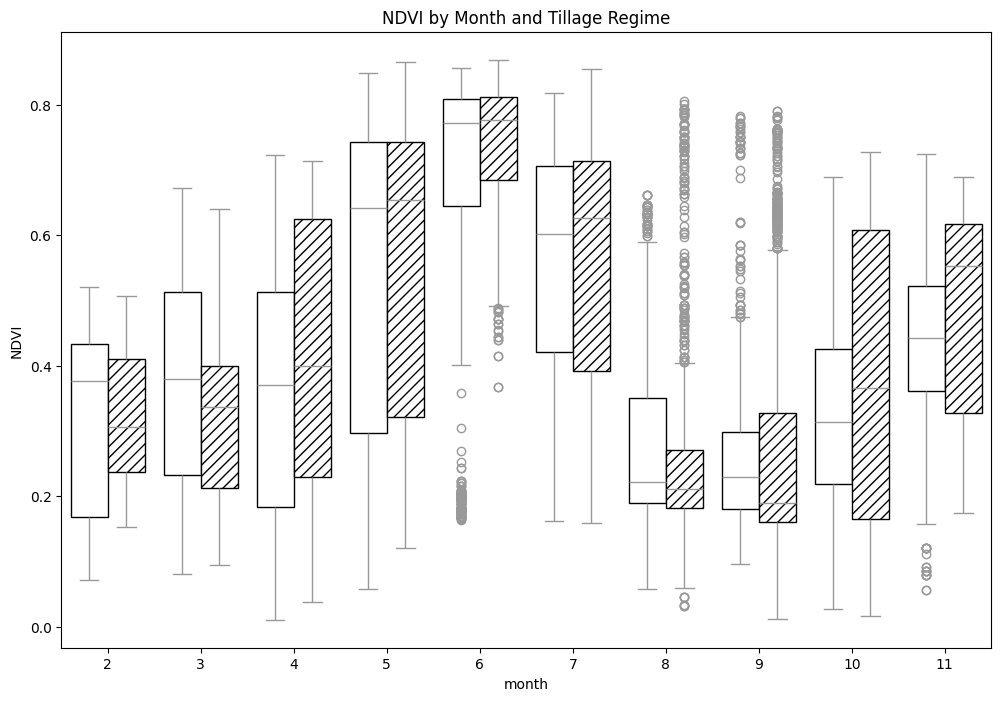

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume 'filtered_df' is your DataFrame and is already defined.

# Create the box plot
plt.figure(figsize=(12, 8))
box_plot = sns.boxplot(x='month', y='NDVI', hue='tillage', data=filtered_df, palette=['white', 'white'])

# Set the title
plt.title('NDVI by Month and Tillage Regime')

# Retrieve the order of the hue
hue_order = box_plot.get_legend_handles_labels()[1]

# Get the number of months to calculate the total number of boxes per hue category
num_months = len(filtered_df['month'].unique())

# Iterate through the patches (boxes) and apply the hatching based on 'tillage' type
for i, patch in enumerate(box_plot.patches):
    # Calculate the hue index, taking into account the number of months
    hue_index = (i // num_months) % len(hue_order)
    tillage_type = hue_order[hue_index]

    if tillage_type == 'MT':
        # Apply crosshatch to 'MT' type
        patch.set_hatch('///')
        patch.set_edgecolor('black')
    else:
        # 'CT' or other tillage types will be plain white with black edge
        patch.set_edgecolor('black')

# Remove the legend since we are manually adjusting the colors and hatching
box_plot.legend_.remove()

# Show the plot
plt.show()


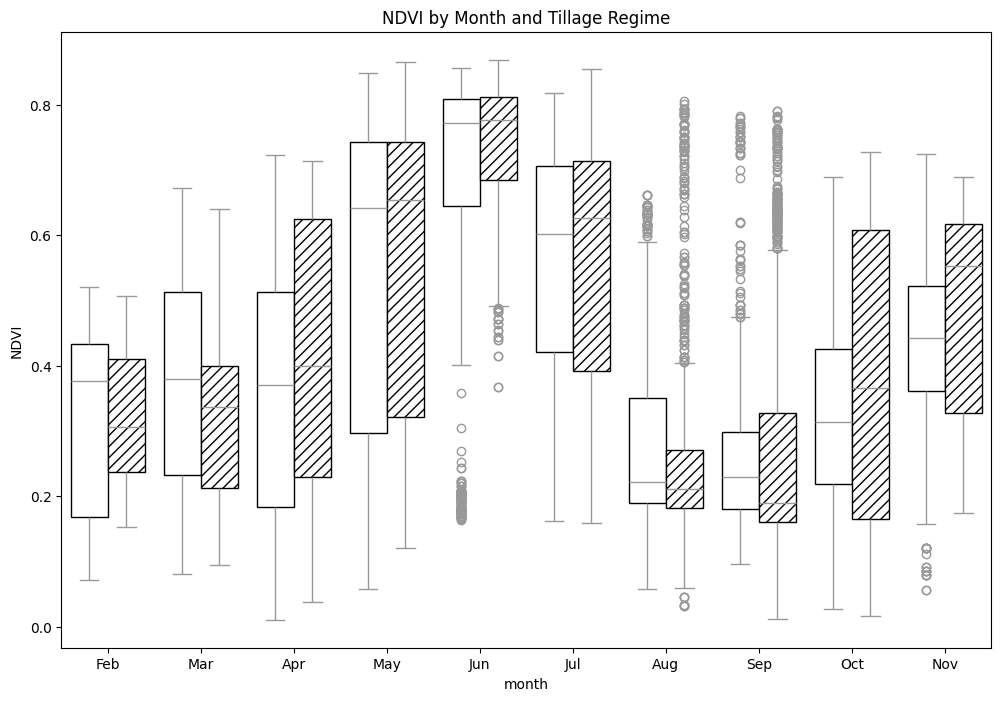

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume 'filtered_df' is your DataFrame and is already defined.

# Create the box plot
plt.figure(figsize=(12, 8))
box_plot = sns.boxplot(x='month', y='NDVI', hue='tillage', data=filtered_df, palette=['white', 'white'])

# Set the title
plt.title('NDVI by Month and Tillage Regime')

# Retrieve the order of the hue
hue_order = box_plot.get_legend_handles_labels()[1]

# Get the number of months to calculate the total number of boxes per hue category
num_months = len(filtered_df['month'].unique())

# Define month number to name mapping
month_names = {2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
               7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov"}

# Set x-axis tick labels to month names using the mapping
box_plot.set_xticklabels([month_names[int(tick.get_text())] for tick in box_plot.get_xticklabels()])

# Iterate through the patches (boxes) and apply the hatching based on 'tillage' type
for i, patch in enumerate(box_plot.patches):
    # Calculate the hue index, taking into account the number of months
    hue_index = (i // num_months) % len(hue_order)
    tillage_type = hue_order[hue_index]

    if tillage_type == 'MT':
        # Apply crosshatch to 'MT' type
        patch.set_hatch('///')
        patch.set_edgecolor('black')
    else:
        # 'CT' or other tillage types will be plain white with black edge
        patch.set_edgecolor('black')

# Remove the legend since we are manually adjusting the colors and hatching
box_plot.legend_.remove()

# Show the plot
plt.show()


In [ ]:
# ANOVA to test differences between groups
anova_series = filtered_df.groupby(['month']).apply(
    lambda x: stats.f_oneway(x[x['tillage'] == 'MT']['NDVI'], x[x['tillage'] == 'CT']['NDVI'])
)
anova_results = pd.DataFrame(anova_series.tolist(), index=anova_series.index, columns=['F-Statistic', 'p-Value'])
anova_results['Significant'] = anova_results['p-Value'] < 0.05

# Outputting ANOVA results
print("ANOVA Results:")
print(anova_results)

# Calculating and plotting confidence intervals
confidence_intervals = filtered_df.groupby(['month', 'tillage'])['NDVI'].apply(
    lambda x: stats.norm.interval(0.95, loc=x.mean(), scale=x.std()/len(x)**0.5)
)

print("Confidence Intervals:")
print(confidence_intervals)

ANOVA Results:
       F-Statistic       p-Value  Significant
month                                        
2         2.600094  1.072764e-01        False
3        45.648983  1.887977e-11         True
4        46.982424  9.501919e-12         True
5         7.809740  5.228945e-03         True
6        80.200740  6.355013e-19         True
7         1.561691  2.114905e-01        False
8        45.105553  2.224434e-11         True
9         2.723922  9.901826e-02        False
10       39.922835  3.272754e-10         True
11        9.909460  1.801685e-03         True
Confidence Intervals:
month  tillage
2      CT         (0.31379689499496144, 0.34524154709137933)
       MT          (0.30659981962930355, 0.3246607560788319)
3      CT          (0.36565349370077266, 0.3874986320502232)
       MT          (0.32389998447053725, 0.3393415429037743)
4      CT          (0.34878020452720704, 0.3729719277204151)
       MT          (0.4078578256063108, 0.43002587993794494)
5      CT           (0.5244244

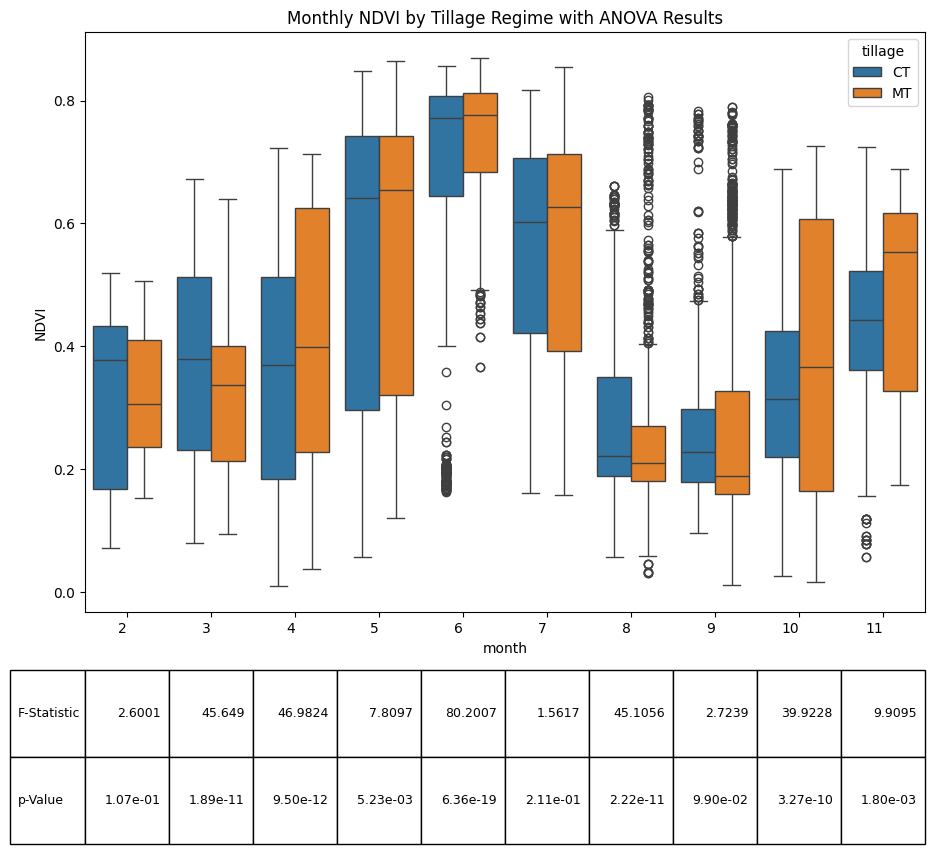

In [ ]:


# Create box plot
fig, ax = plt.subplots(figsize=(12, 10))
sns.boxplot(x='month', y='NDVI', hue='tillage', data=filtered_df, ax=ax)
ax.set_title('Monthly NDVI by Tillage Regime with ANOVA Results')
ax.set_xticklabels(ax.get_xticklabels(), ha='right')

# Adjust the axes to make room for the table below it
plt.subplots_adjust(left=0.2, bottom=0.3)  # Adjust bottom to give more room

# Prepare the table data directly below the boxplot
f_stats = anova_results['F-Statistic'].round(4).tolist()
p_values = ['{:.2e}'.format(p) for p in anova_results['p-Value']]

# Add table at the bottom of the axes with row headings and formatted p-values
the_table = ax.table(cellText=[f_stats, p_values], rowLabels=['F-Statistic', 'p-Value'], loc='bottom', bbox=[0.0, -0.4, 1.0, 0.3])

# Adjusting table font size and layout
the_table.auto_set_font_size(False)
the_table.set_fontsize(9)
the_table.scale(1, 1.5)  # Adjust scale to ensure readability

plt.show()



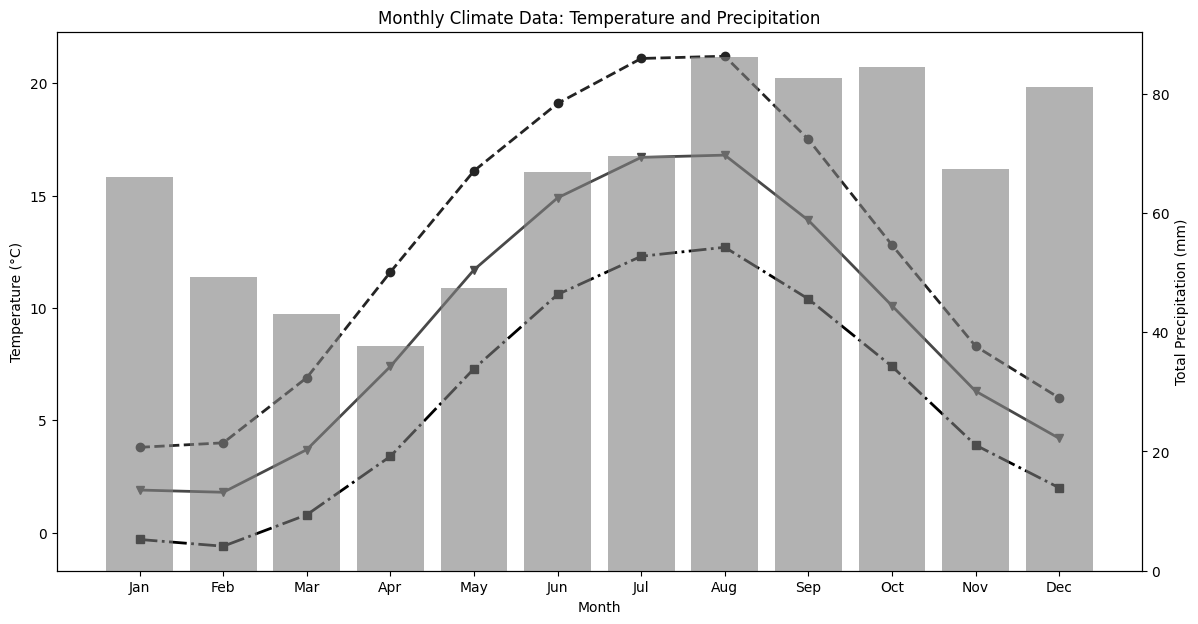

In [ ]:

df = pd.DataFrame(climat_data)

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

# Temperature plot (line)
ax1.set_xlabel('Month')
ax1.set_ylabel('Temperature (°C)')
ax1.plot(df['Month'], df['Average of Maximum Temperature'], linestyle='--', linewidth=2, label='Avg of Max Temp', marker='o')
ax1.plot(df['Month'], df['Average Temperature'], linestyle='-', linewidth=2, label='Avg Temp', marker='v')
ax1.plot(df['Month'], df['Average of Minimum Temperature'], color="black", linestyle='-.', linewidth=2, label='Avg of Min Temp', marker='s')
ax1.tick_params(axis='y')
#ax1.legend(loc='upper left')

# Precipitation plot (bar) using twin axis
ax2 = ax1.twinx()
ax2.set_ylabel('Total Precipitation (mm)')
ax2.bar(df['Month'], df['Total Precipitation'], color='grey', label='Total Precipitation', alpha=0.6)
ax2.tick_params(axis='y')
#ax2.legend(loc='upper right')

# Title
plt.title('Monthly Climate Data: Temperature and Precipitation')

plt.show()


UnboundLocalError: local variable 'boxprops' referenced before assignment

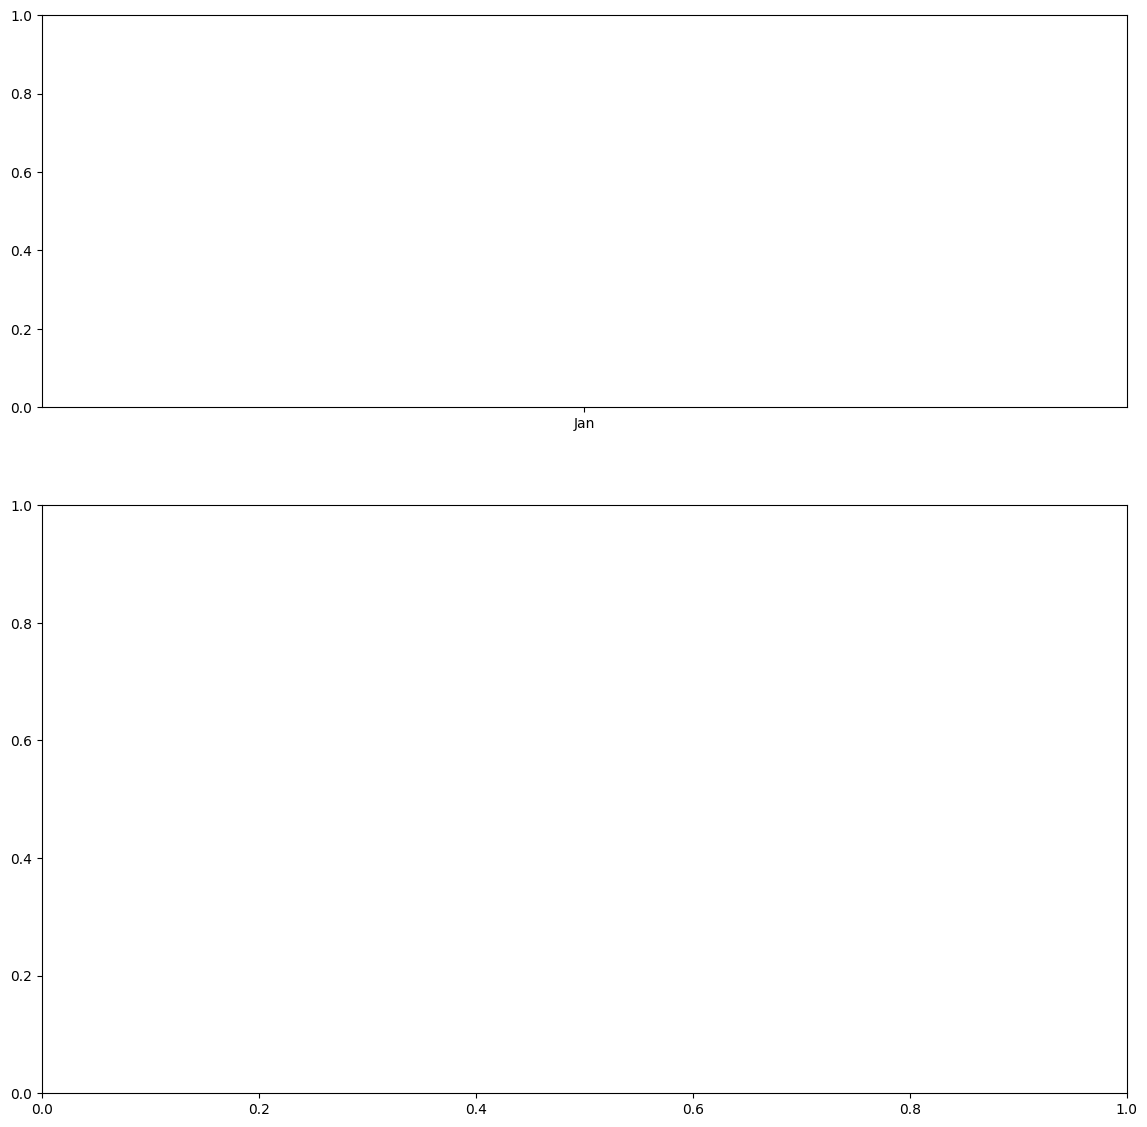

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample NDVI data (assuming it's preloaded in 'filtered_df')
# Sample ANOVA results (assuming it's preloaded in 'anova_results')

# Sample climate data
climat_data = {
    "Month": ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
    "Average of Maximum Temperature": [3.8, 4, 6.9, 11.6, 16.1, 19.1, 21.1, 21.2, 17.5, 12.8, 8.3, 6],
    "Average Temperature": [1.9, 1.8, 3.7, 7.4, 11.7, 14.9, 16.7, 16.8, 13.9, 10.1, 6.3, 4.2],
    "Average of Minimum Temperature": [-0.3, -0.6, 0.8, 3.4, 7.3, 10.6, 12.3, 12.7, 10.4, 7.4, 3.9, 2],
    "Total Precipitation": [66, 49.3, 43.1, 37.7, 47.4, 66.9, 69.5, 86.1, 82.6, 84.5, 67.4, 81.2]
}

# Create DataFrame for climate data
df_climate = pd.DataFrame(climat_data)

# Adjust NDVI data to include January and December with NaNs
months_complete = pd.Categorical(df_climate['Month'], categories=df_climate['Month'], ordered=True)
filtered_df['month'] = pd.Categorical(filtered_df['month'], categories=months_complete)

# Create plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14), gridspec_kw={'height_ratios': [1, 1.5]})

# Plot for NDVI data
sns.boxplot(x='month', y='NDVI', hue='tillage', data=filtered_df, ax=ax1)
ax1.set_title('Monthly NDVI by Tillage Regime with ANOVA Results')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Table of ANOVA results below NDVI plot
f_stats = anova_results['F-Statistic'].round(4).tolist()
p_values = ['{:.2e}'.format(p) for p in anova_results['p-Value']]
the_table = ax1.table(cellText=[f_stats, p_values], rowLabels=['F-Statistic', 'p-Value'], loc='bottom', bbox=[0.0, -0.3, 1.0, 0.2])
the_table.auto_set_font_size(False)
the_table.set_fontsize(9)
the_table.scale(1, 1.5)

# Plot for climate data
ax2.plot(df_climate['Month'], df_climate['Average of Maximum Temperature'], 'r-o', label='Avg of Max Temp')
ax2.plot(df_climate['Month'], df_climate['Average Temperature'], 'g-o', label='Avg Temp')
ax2.plot(df_climate['Month'], df_climate['Average of Minimum Temperature'], 'b-o', label='Avg of Min Temp')
ax2.bar(df_climate['Month'], df_climate['Total Precipitation'], color='grey', alpha=0.5, label='Total Precipitation')
ax2.set_xlabel('Month')
ax2.set_ylabel('Temperature (°C) / Precipitation (mm)')
ax2.legend(loc='upper left')

plt.subplots_adjust(hspace=0.4)  # Adjust horizontal space between plots
plt.show()


In [ ]:
anova_series = pd.Series({
    2: (2.6000940499315957, 0.10727637864682718),
    3: (45.64898321851796, 1.8879768076119414e-11),
    4: (46.98242400805352, 9.501919396649616e-12),
    5: (7.80974019887449, 0.005228945052310936),
    6: (80.20074048571435, 6.355013018929455e-19),
    7: (1.561690913280039, 0.21149052346524505),
    8: (45.1055533122589, 2.2244340131326548e-11),
    9: (2.7239215781894464, 0.09901825630868766),
    10: (39.92283502368312, 3.272753841767112e-10),
    11: (9.909460311539735, 0.0018016848375705442)
})
anova_series

In [ ]:
anova_results = pd.DataFrame(anova_series.tolist(), index=anova_series.index, columns=['F-Statistic', 'p-Value'])
anova_results['Significant'] = anova_results['p-Value'] < 0.05

In [ ]:
anova_results
